## Configurations

In [1]:
class CFG:
    text_file_path = "story.txt"
    # text_file_path = "corpus.txt"
    stopwords = []
    window_size = 1
    embed_size = 2
    n_epoch = 10000
    lr = 0.5
    batch_size = 64
    dropout_rate = 0.2

## Important libraries

In [2]:
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np
import torch
import torch.optim as optim
import re
from helper import plot_embeddings
import torch.nn.functional as F
import nltk
from nltk.corpus import stopwords
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import LambdaLR

# Download stopwords once if not already downloaded
nltk.download('stopwords')

# Get the list of English stopwords
stopwords = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sujandas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Corpus

In [3]:
# Reading the file and splitting the sentences
with open(CFG.text_file_path, "r") as file:
    text = file.read()

# Splitting text by '.' or '\n'
corpus = [re.sub(r'[^\w\s]', '', sentence.strip()) for sentence in re.split(r'[.]', text) if sentence.strip()]

# Displaying the first few sentences to verify
print(corpus[:5])

['Countries are known for their capitals and each capital represents unique aspects of its nation', 'France known for the famous city of Paris attracts tourists with its rich culture and history', 'Germany is home to Berlin a capital known for its vibrant arts and culture scenes', 'Italy famous for ancient history has Rome as its capital where visitors can see old ruins and rich architecture', 'Spain has its capital in Madrid where art and music flourish']


## Preprocess the corpus

In [4]:
def preprocess(corpus, stopwords = stopwords):
    # Tokenize and remove stopwords
    tokenized = [[word for word  in sentence.lower().split() if word not in list(stopwords)]
                 for sentence in corpus]
    return tokenized

tokenized_corpus = preprocess(corpus)
print(tokenized_corpus[:6])

[['countries', 'known', 'capitals', 'capital', 'represents', 'unique', 'aspects', 'nation'], ['france', 'known', 'famous', 'city', 'paris', 'attracts', 'tourists', 'rich', 'culture', 'history'], ['germany', 'home', 'berlin', 'capital', 'known', 'vibrant', 'arts', 'culture', 'scenes'], ['italy', 'famous', 'ancient', 'history', 'rome', 'capital', 'visitors', 'see', 'old', 'ruins', 'rich', 'architecture'], ['spain', 'capital', 'madrid', 'art', 'music', 'flourish'], ['japans', 'capital', 'tokyo', 'city', 'innovation', 'modernity', 'keeping', 'historical', 'traditions', 'alive']]


## Vocab

In [5]:
vocab = {word: idx for idx, word in enumerate(list(set([word for sentence in tokenized_corpus for word in sentence])))}
idx2word = {v: k for k, v in vocab.items()}
vocab_size = len(vocab)
vocab_size

180

## Create Dataset

In [6]:
def one_hot_encoding(idx, vocab_size = vocab_size):
    encod = torch.zeros(vocab_size)
    encod[idx] = 1
    return encod

one_hot_encoding(0)

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [7]:
class Word2VecDataset(Dataset):
    def __init__(self, tokenized_corpus, vocab, window_size = CFG.window_size):
        self.pairs = []
        self.vocab = vocab
        self.window_size = window_size
        
        for sentence in tokenized_corpus:
            sentence_length = len(sentence)
            for idx, word in enumerate(sentence):
                target_word = self.vocab[word]
                context_indices = list(range(max(0, idx - window_size), min(sentence_length, idx + window_size + 1)))
                context_indices.remove(idx)  # Remove target word from context
                context_words = [self.vocab[sentence[context_idx]] for context_idx in context_indices]
                if len(context_words) > 0:
                    self.pairs.append((target_word, context_words))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, index):
        y, context_indices = self.pairs[index]
        y = torch.tensor(y, dtype = torch.long)
        
        context_vectors = torch.cat(([one_hot_encoding(c_idx, vocab_size) for c_idx in context_indices]), dim = 0)
        padding_needed = 2 * CFG.window_size * vocab_size - len(context_vectors)

        padding_tensor = torch.zeros(padding_needed, dtype = context_vectors.dtype)
        # Concatenate the original tensor with the padding tensor
        x = torch.cat((context_vectors, padding_tensor))
        # x = torch.sum(torch.stack([one_hot_encoding(c_idx, vocab_size) for c_idx in context_indices]), dim = 0)
        return x, y

# Create the dataset and dataloader
dataset = Word2VecDataset(tokenized_corpus, vocab)
dataloader = DataLoader(dataset, batch_size = CFG.batch_size, shuffle = True)
print(len(dataset))

256


## Define Model

In [13]:
class Word2Vec(nn.Module):
  def __init__(self, vocab_size, embed_size):
    super(Word2Vec, self).__init__()
    self.input_dim =  2 * CFG.window_size * vocab_size
    # self.input_dim = vocab_size
    self.hidden_layer = nn.Linear(self.input_dim, embed_size)
    self.batch_norm = nn.BatchNorm1d(embed_size)
    self.dropout = nn.Dropout(CFG.dropout_rate)
    self.output_layer = nn.Linear(embed_size, vocab_size)

  def forward(self, contexts):
    y = self.hidden_layer(contexts)
    y = self.dropout(y)
    y = self.batch_norm(y)
    y = self.output_layer(y)
    y = nn.Softmax(dim = -1)(y)
    return y
  
# Initialize the model, optimizer, and loss function  
model = Word2Vec(vocab_size, CFG.embed_size)
optimizer = optim.SGD(model.parameters(), lr = CFG.lr)
scheduler = StepLR(optimizer, step_size = 100, gamma = 0.1)
lambda_lr = lambda epoch: 0.99 ** epoch  # 5% decay per epoch
scheduler = LambdaLR(optimizer, lr_lambda = lambda_lr)
loss_fn = nn.CrossEntropyLoss()

## Train the model

In [14]:
for epoch in range(CFG.n_epoch):
    total_loss = 0
    for x, y in dataloader:
        # Forward pass: predict context word embedding for each one-hot target word
        yhat = model(x)  # Get target embedding

        # Calculate loss based on predicted and actual context indices
        optimizer.zero_grad()

        loss = loss_fn(yhat, y)  # CrossEntropyLoss expects class indices for target
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if epoch > 1000:
        scheduler.step()
    
    # Average the loss over all batches for this epoch
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{CFG.n_epoch}], Average Loss: {avg_loss:.6f}")

Epoch [1/10000], Average Loss: 5.192605
Epoch [2/10000], Average Loss: 5.192780
Epoch [3/10000], Average Loss: 5.192679
Epoch [4/10000], Average Loss: 5.192363
Epoch [5/10000], Average Loss: 5.192345
Epoch [6/10000], Average Loss: 5.192455
Epoch [7/10000], Average Loss: 5.192215
Epoch [8/10000], Average Loss: 5.192285
Epoch [9/10000], Average Loss: 5.192156
Epoch [10/10000], Average Loss: 5.191888
Epoch [11/10000], Average Loss: 5.191793
Epoch [12/10000], Average Loss: 5.191556
Epoch [13/10000], Average Loss: 5.191480
Epoch [14/10000], Average Loss: 5.191721
Epoch [15/10000], Average Loss: 5.191486
Epoch [16/10000], Average Loss: 5.191346
Epoch [17/10000], Average Loss: 5.191062
Epoch [18/10000], Average Loss: 5.190837
Epoch [19/10000], Average Loss: 5.190937
Epoch [20/10000], Average Loss: 5.190361
Epoch [21/10000], Average Loss: 5.190210
Epoch [22/10000], Average Loss: 5.190881
Epoch [23/10000], Average Loss: 5.190432
Epoch [24/10000], Average Loss: 5.189971
Epoch [25/10000], Average

In [15]:
output_layer_weights = list(model.output_layer.parameters())
raw_embeddings = output_layer_weights[0].detach()
embeddings = {idx2word[idx]: embed for idx, embed in enumerate(raw_embeddings)}
embeddings

{'ancient': tensor([0.2570, 0.3530]),
 'countrys': tensor([ 0.4118, -0.5390]),
 'categorize': tensor([ 0.1711, -0.6564]),
 'identity': tensor([-0.3925,  0.1791]),
 'making': tensor([0.2194, 0.5250]),
 'passion': tensor([ 0.2879, -0.1704]),
 'depth': tensor([ 0.9091, -0.4385]),
 'engaging': tensor([-0.2744,  0.0665]),
 'purple': tensor([ 0.0680, -1.3686]),
 'water': tensor([0.1504, 0.1572]),
 'keeping': tensor([ 0.0796, -0.6432]),
 'home': tensor([-0.1541, -0.1940]),
 'sometimes': tensor([-0.5435,  0.1555]),
 'calculate': tensor([-0.4700, -0.1031]),
 'charm': tensor([-0.5206,  0.6375]),
 'red': tensor([-0.1245,  0.1483]),
 'traditions': tensor([0.1243, 0.1509]),
 'us': tensor([ 0.2192, -0.2309]),
 'may': tensor([0.4716, 0.3916]),
 'pairs': tensor([-0.7319,  0.7369]),
 'offer': tensor([-0.3213, -0.5247]),
 'simple': tensor([0.4320, 0.1103]),
 'capital': tensor([ 1.7326, -0.7227]),
 'giving': tensor([0.4557, 0.5897]),
 'forming': tensor([-0.0536,  0.4545]),
 'knowledge': tensor([ 0.7117, 

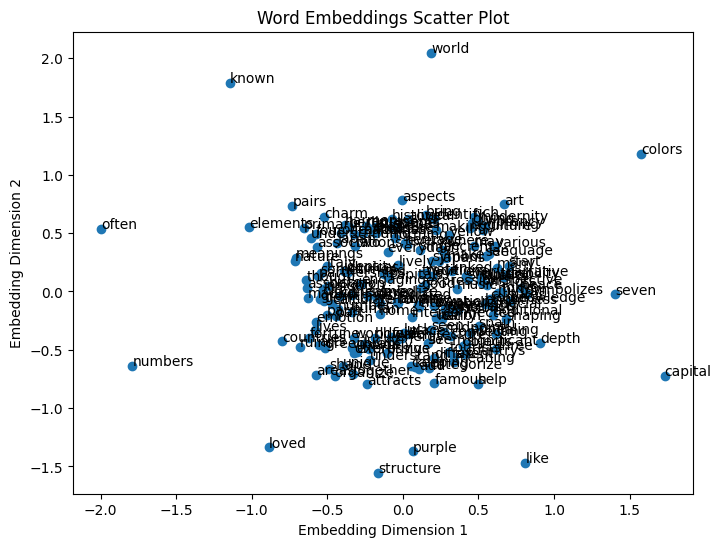

In [16]:
words = ['holmes', 'man', 'woman', 'friend', 'Atkinson', 'Baker', 'cigarette', 'clues', 'german-speaking', 'watson', 'address','european', 'coat'
         'two', 'double', 'high', 'little', "men's", 'white', 'seven', 'he', 'she', 'beauties', 'seventeen', 'one', 'too', 'blue', 'window', 'door']
# words = [word.lower() for word in words]
words = list(vocab.keys())
plot_embeddings(embeddings, words = words)

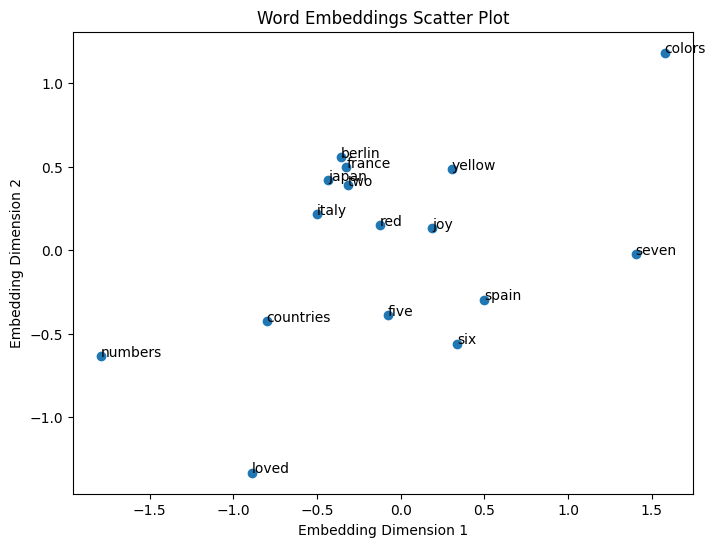

In [17]:
words = ['countries', 'italy', 'spain', 'yellow', 'colors', 'berlin', 'loved', 'joy', 'red', 'numbers', 'seven', 'two', 'five', 'france', 'six', 'japan', 'red']
plot_embeddings(embeddings, words = words)